# Geometric Accuracy of Sentinel-1 NRB sample product and comparison to GEE product

This notebooks compares geometric accuracy assessment for data prodcued by Sinergise and from GEE.

One GRD scene from 2019 11 16 is used.


### Prepare input data

In [1]:
!ls s1_sample_cr/

10m
20m
GEE_S1-VVVH_20191116_S28E150_Float32
GEE_S1-VVVH_20191116_S28E150_Float32.zip
QLD_corner_reflector_positions_GDA2020.csv
QLD_corner_reflector_positions_GDA2020.txt
S28E150_10k_Bilinear.tar
S28E150_5k_Bilinear.tar
SinergiseTool_GEE_S1-VVVH_20191116_S28E150_Float32
SinergiseTool_GEE_S1-VVVH_20191116_S28E150_Float32.zip


### Load S1 sample data

HH band is available in ascending pass.

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

In [3]:
#!pip install photutils #--user
#from photutils.centroids import centroid_2dg
from scipy import interpolate
from scipy import ndimage

In [4]:
# sinergise 
def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*_{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        date = np.datetime64('-'.join(fname.split('/')[-1].split('/')[-1].split('_')[4:7]))
        data.append(xr.open_rasterio(fname).squeeze().to_dataset(name=band).expand_dims({'time':[date]}))
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby('time')

data = [load_s1_sample_combined('s1_sample_cr/SinergiseTool_GEE_S1-VVVH_20191116_S28E150_Float32', 'VV'),load_s1_sample_combined('s1_sample_cr/SinergiseTool_GEE_S1-VVVH_20191116_S28E150_Float32', 'VH')]
combined = xr.combine_by_coords(data).squeeze()

In [5]:
# GEE
data = []
for band in ['VV', 'VH']:
    d = []
    for chunk in ['north', 'south']:
        fname = f's1_sample_cr/GEE_S1-VVVH_20191116_S28E150_Float32/GEE_S1-{band}_20191116_S28E150-{chunk}.tif'
        d.append(10**(xr.open_rasterio(fname)/10).squeeze().to_dataset(name=band).expand_dims({'chunk':[chunk]}))
    data.append(xr.concat(d, dim='chunk').max(dim='chunk'))
    
gee = xr.combine_by_coords(data)

In [6]:
x_slice = slice(np.max([combined.x.values[0], gee.x.values[0]]), np.min([combined.x.values[-1], gee.x.values[-1]]))
y_slice = slice(np.min([combined.y.values[0], gee.y.values[0]]), np.max([combined.y.values[-1], gee.y.values[-1]]))

In [7]:
combined = combined.sel(x=x_slice, y = y_slice)
gee = gee.sel(x=x_slice, y = y_slice)

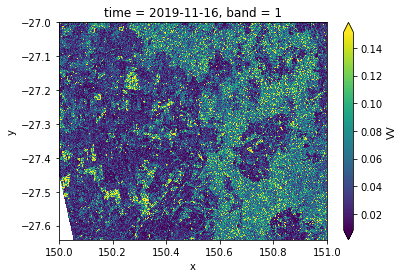

In [8]:
combined.VV.plot.imshow(robust=True);

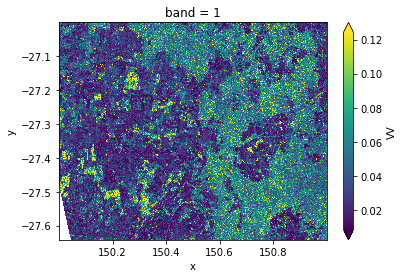

In [9]:
gee.VV.plot.imshow(robust=True);

### Load corner reflector locations

In [10]:
import pandas as pd

In [11]:
cr_locations = pd.read_csv('s1_sample_cr/QLD_corner_reflector_positions_GDA2020.txt', sep="\s+", header=0)

In [12]:
cr_locations.head()

,Name,Latitude,Longitude,Height,X,Y,Z,veloX,veloY,veloZ,Azimuth,Elevation
0,SB01-CRApex,-26.834710,151.165604,409.4544,-4.989394e+06,2.746844e+06,-2.862070e+06,-0.0325,-0.0083,0.0487,257.10,53.32
1,SB02-CRApex,-26.951633,151.237613,432.7094,-4.987723e+06,2.737762e+06,-2.873636e+06,-0.0325,-0.0082,0.0486,256.21,53.33
2,SB03-CRApex,-27.100732,151.258809,391.8599,-4.982121e+06,2.732289e+06,-2.888335e+06,-0.0326,-0.0081,0.0485,258.46,54.34
3,SB04-CRApex,-27.308871,151.271959,385.2420,-4.973496e+06,2.726074e+06,-2.908845e+06,-0.0326,-0.0079,0.0484,258.51,54.67
4,SB05-CRApex,-27.456930,151.190830,403.0057,-4.963033e+06,2.729485e+06,-2.923422e+06,-0.0327,-0.0077,0.0484,258.20,55.36


In [13]:
col_lat = [n for n in list(cr_locations.columns) if 'Latitude' in n]
col_lon = [n for n in list(cr_locations.columns) if 'Longitude' in n]

In [14]:
cr_locations= cr_locations[cr_locations[col_lat].notnull().values & cr_locations[col_lon].notnull().values]

In [15]:
len(cr_locations)

40

### Find peak backscatter in each stamp around a CR by calculating center of mass

####  Sinergise data

15
VV:
RMSE Latitude (pixel) 0.16727786382163468
RMSE Longitude (pixel) 0.28644484179257035
RMSE Latitude (meter) 3.7242743601248747
RMSE Longitude (meter) 5.680171181643588
mean, std Latitude (meter) 1.1192059302396635 3.55212578538541
mean, std Longitude (meter) -3.607841003484317 4.3872346582273885


Text(0.5, 1.0, 'center of mass')

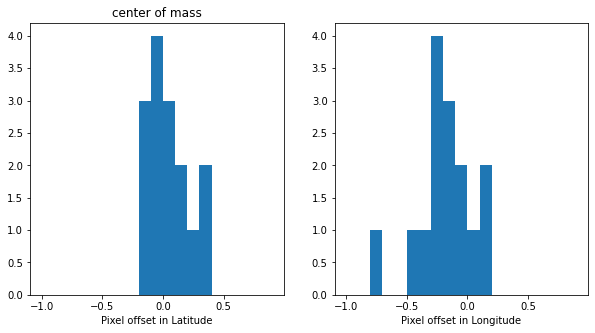

In [16]:
ps = 0.0002 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon_1 = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon_2 =111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon = (mpd_lon_1+mpd_lon_2)/2

hs = ps * 4

s1 = combined.VV

data_crs = []
true_lats = []
true_lons = []

for idx, row in cr_locations.iterrows():
    try:
        # is the CR in the scene?
        d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
        x0, y0 = d.x.values, d.y.values
        #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        # is it visible?
        peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
        try:
            if peak.max()>2: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
                true_lats.append(row[col_lat].values[0])
                true_lons.append(row[col_lon].values[0])
            else:
                print("not visible?", peak.max().values)
        except: 
            #print(i, data, peak)
            pass
    except KeyError:
        pass
    # 

print(len(data_crs))
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    y, x = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print('VV:')
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)
print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)

f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('center of mass')


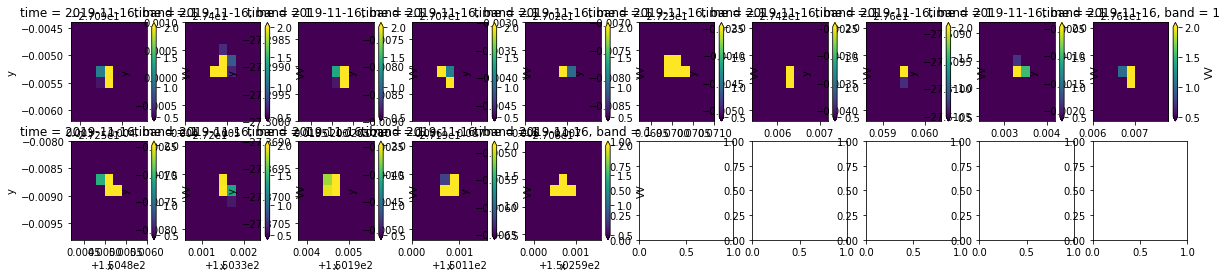

In [17]:
# visual check selected stamps

f, ax = plt.subplots(2,10,figsize=(20,4))
ax = ax.flatten()
for i in range(len(data_crs)):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);

In [18]:
data_crs[0].shape

(9, 9)

#### GEE data

15
Center of Mass:
RMSE Latitude (pixel) 0.2645665426628082
RMSE Longitude (pixel) 0.40766696492405835
RMSE Latitude (meter) 5.327490432561295
RMSE Longitude (meter) 7.311567626511933
mean, std Latitude (meter) -3.6689048424892783 3.8628087664018333
mean, std Longitude (meter) -5.8440639510811865 4.393852261140635


Text(0.5, 1.0, 'center of mass')

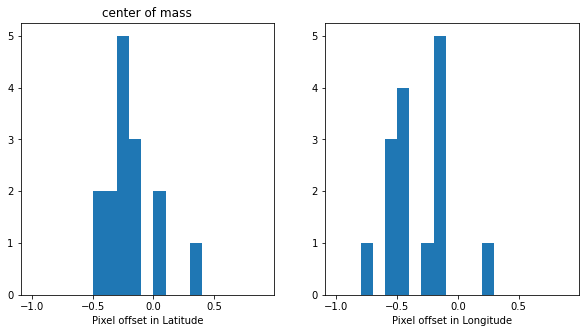

In [19]:
ps = 0.00018089 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon_1 = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon_2 =111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon = (mpd_lon_1+mpd_lon_2)/2

hs = ps * 4 #0.0008

s1 = gee.VV

data_crs = []
true_lats = []
true_lons = []

for idx, row in cr_locations.iterrows():
    try:
        # is the CR in the scene?
        d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
        x0, y0 = d.x.values, d.y.values
        #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        # is it visible?
        peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
        try:
            if peak.max()>2: 
                #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                data_crs.append(data)
                true_lats.append(row[col_lat].values[0])
                true_lons.append(row[col_lon].values[0])
            else:
                print("not visible?", peak.max().values)
        except: 
            #print(i, data, peak)
            pass
    except KeyError:
        pass
    # 
  
print(len(data_crs))
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    y, x = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print('Center of Mass:')
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)
print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)

f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('center of mass')


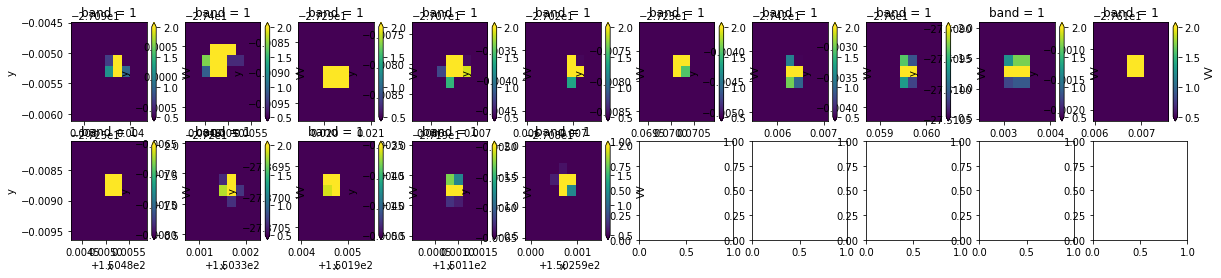

In [20]:
# visual check selected stamps

f, ax = plt.subplots(2,10,figsize=(20,4))
ax = ax.flatten()
for i in range(len(data_crs)):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);

In [21]:
data_crs[0].shape

(9, 9)